# DAML 03 - Pandas Introduction

Michal Grochmal <michal.grochmal@city.ac.uk>

Wrapper on top of `NumPy` (and `Matplotlib` to some extent) to make up for the shortcomings
of those two libraries in the context of real-world data.  Instead of working towards
numerical computing it attempts to make working with messy data less annoying.

First some accumulated boilerplate from previous lectures (and one new one):

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn-whitegrid')
mpl.rcParams['figure.figsize'] = (12.5, 6.0)
import pandas as pd
pd.options.display.max_rows = 12

## General ideas behind pandas

Originally built as an enhanced version of R's `data.frame`,
`pandas` incorporates several known APIs into a single structure.
The `DataFrame` includes APIs that make it easy for use from different perspectives.

* R `data.frame` like structure, extended by multi-indexes
* SQL-like joins, without need for external libraries (e.g. `sqldf`)
* Looks like a spreadsheet (yes, that is intentional)
* One can move between two and multidimensional representations (`stack`, `unstack`)
* Aggregation across dimensions with `groupby` (similar to SQL)

You will use `pandas` (rather than `NumPy`) for tasks around messy data.
`pandas` is built atop `NumPy`, and uses the continuous memory and broadcast operations
of `NumPy` arrays, we saw before, to boost its performance.  `pandas` excels at:

* Importing data (very resilient compared to `numpy.load`)
* Clean up messy data (`dropna` or `fillna`)
* Gain insight into data (`describe`)

Let's use some data about the British isles and the United Kingdom to demonstrate
some of the features:

In [2]:
country = ['Northern Ireland', 'Scotland', 'Wales', 'England', 'Isle of Man']
capital = ['Belfast', 'Edinburgh', 'Cardiff', 'London', 'Douglas']
area = [14130, 77933, 20779, 130279, 572]
population2017 = [1876695, 5404700, np.nan, 55268100, np.nan]
population2011 = [1810863, 5313600, 3063456, 53012456, 83314]

# Series

The main feature of `pandas` is its `DataFrame` but that is a collection of `Series` data structures.
A `Series` is pretty similar to a `NumPy` array: it is a list of several data for the same data type.
The difference is that the `Series` adds labels (an index) to the data.

In [3]:
series = pd.Series(area)
series

0     14130
1     77933
2     20779
3    130279
4       572
dtype: int64

In [4]:
uk_area = pd.Series(area, index=country)
uk_area

Northern Ireland     14130
Scotland             77933
Wales                20779
England             130279
Isle of Man            572
dtype: int64

### Selection from the index

Selecting from a `Series` works both as a list or as a dictionary.
You can say that a `Series.index` maps keys over `Series.values`.

In [5]:
uk_area.values, uk_area.values.dtype, uk_area.index

(array([ 14130,  77933,  20779, 130279,    572]),
 dtype('int64'),
 Index(['Northern Ireland', 'Scotland', 'Wales', 'England', 'Isle of Man'], dtype='object'))

In [6]:
uk_area['Wales'], uk_area[2], uk_area.values[2]

(20779, 20779, 20779)

Slicing works too, so does fancy indexing.

In [7]:
uk_area[0:3]

Northern Ireland    14130
Scotland            77933
Wales               20779
dtype: int64

In [8]:
uk_area[['Wales', 'Scotland']]

Wales       20779
Scotland    77933
dtype: int64

### Sorted and unsorted indexes

Slicing also works on indexes
but it is only likely to produce meaningful results if the index is sorted.

Note: In older versions of `pandas` slicing over an unsorted index produced an error,
this still happens over a multi-index (outlined in a later section).

In [9]:
uk_area['England':'Scotland']  # oops

Series([], dtype: int64)

In [10]:
uk_area.sort_index(inplace=True)
uk_area['England':'Scotland']

England             130279
Isle of Man            572
Northern Ireland     14130
Scotland             77933
dtype: int64

### Implicit indexes

If you do not define an index `pandas` will create an implicit one.
This is what happened with our `series` variable above.
Slicing  may be counterintuitive.

In [11]:
uk_area

England             130279
Isle of Man            572
Northern Ireland     14130
Scotland             77933
Wales                20779
dtype: int64

In [12]:
uk_area['England':'Scotland']  # Inclusive!

England             130279
Isle of Man            572
Northern Ireland     14130
Scotland             77933
dtype: int64

In [13]:
uk_area[0:3]  # Exclusive!

England             130279
Isle of Man            572
Northern Ireland     14130
dtype: int64

This can give us a headache with numerical indexes,
therefore `pandas` allows us to choose which index to select from:

* `loc` always refers to the explicit index
* `iloc` always refers to the implicit index
* `ix` is what is actually used when we do plain `[]` indexing (and you would normally not need to write it out)

In [14]:
series.index = [1, 2, 3, 4, 5]
series

1     14130
2     77933
3     20779
4    130279
5       572
dtype: int64

In [15]:
series[1], series.loc[1], series.iloc[1]

(14130, 14130, 77933)

In [16]:
list(series[1:3]), list(series.loc[1:3]), list(series.iloc[1:3])

([77933, 20779], [14130, 77933, 20779], [77933, 20779])

### Like an array

The `NumPy` vectorized operations, selection and broadcasting work as if we were working on an array.

In [17]:
uk_area[uk_area > 20000]

England     130279
Scotland     77933
Wales        20779
dtype: int64

In [18]:
uk_area * 0.386  # convert to square miles (1/1.61**2)

England             50287.694
Isle of Man           220.792
Northern Ireland     5454.180
Scotland            30082.138
Wales                8020.694
dtype: float64

In [19]:
uk_area.sum()  # Isle of Man is not part of the UK!  We'll fix that later.

243693

### More than an array

The `Series` align the indexes when performing operations.
For example what if we would like to know the population sum and population growth
between 2011 and 2017?

In [20]:
p11 = pd.Series(population2011, index=country)
p17 = pd.Series(population2017, index=country).dropna()  # disregard nulls, we will see more later

In [21]:
p11

Northern Ireland     1810863
Scotland             5313600
Wales                3063456
England             53012456
Isle of Man            83314
dtype: int64

In [22]:
p17

Northern Ireland     1876695.0
Scotland             5404700.0
England             55268100.0
dtype: float64

In [23]:
p17 - p11

England             2255644.0
Isle of Man               NaN
Northern Ireland      65832.0
Scotland              91100.0
Wales                     NaN
dtype: float64

## Data Frames

The `DataFrame` is just a collection of `Series` with a common index.
It can be understood as a two-dimensional representation of data,
similar to a spreadsheet.  One important thing to note is that,
contrary to two dimensional `NumPy` arrays, **indexing a data frame
produces the column** not the row.  Yet, indexing it with two numbers
produces the row and the column just like in a `NumPy` array.

In [24]:
array = np.array([area, capital, population2011, population2017]).T  # transpose
data = pd.DataFrame({'capital': capital,
                     'area': area,
                     'population 2011': population2011,
                     'population 2017': population2017},
                    index=country)

In [25]:
array

array([['14130', 'Belfast', '1810863', '1876695'],
       ['77933', 'Edinburgh', '5313600', '5404700'],
       ['20779', 'Cardiff', '3063456', 'nan'],
       ['130279', 'London', '53012456', '55268100'],
       ['572', 'Douglas', '83314', 'nan']],
      dtype='<U21')

In [26]:
data

,area,capital,population 2011,population 2017
Northern Ireland,14130,Belfast,1810863,1876695.0
Scotland,77933,Edinburgh,5313600,5404700.0
Wales,20779,Cardiff,3063456,NaN
England,130279,London,53012456,55268100.0
Isle of Man,572,Douglas,83314,NaN


In [27]:
array[0]

array(['14130', 'Belfast', '1810863', '1876695'],
      dtype='<U21')

In [28]:
data['area']  # get column

Northern Ireland     14130
Scotland             77933
Wales                20779
England             130279
Isle of Man            572
Name: area, dtype: int64

In [29]:
data.iloc[0]  # but `iloc` does the same as a `NumPy` array

area                    14130
capital               Belfast
population 2011       1810863
population 2017    1.8767e+06
Name: Northern Ireland, dtype: object

In [30]:
data.area  # this works too

Northern Ireland     14130
Scotland             77933
Wales                20779
England             130279
Isle of Man            572
Name: area, dtype: int64

In [31]:
data.loc['England', 'area']  # still [row, column]

130279

### Summarize

Data frames have several useful methods to give a feel for the data.
With a reasonable amount of data you'd rather not want thousands of rows to
be printed, moreover, looking at the beginning or end of sorted values will show outliers.
The `describe` and `info` methods print two distinct types of statistics about the data frame:
one gives the statistical view of each column, the other gives you a memory layout.
The data frame can also access plots (from `Matplotlib`) directly.

Let's see some examples but firsts let's order the index on the data frame.

In [32]:
data.sort_index(inplace=True)

In [33]:
data.head(3)

,area,capital,population 2011,population 2017
England,130279,London,53012456,55268100.0
Isle of Man,572,Douglas,83314,NaN
Northern Ireland,14130,Belfast,1810863,1876695.0


In [34]:
data.sort_values('area').tail(3)

,area,capital,population 2011,population 2017
Wales,20779,Cardiff,3063456,NaN
Scotland,77933,Edinburgh,5313600,5404700.0
England,130279,London,53012456,55268100.0


In [35]:
len(data)  # number of rows

5

In [36]:
data.describe()

,area,population 2011,population 2017
count,5.000000,5.000000e+00,3.000000e+00
mean,48738.600000,1.265674e+07,2.084983e+07
std,54315.434283,2.263990e+07,2.985925e+07
min,572.000000,8.331400e+04,1.876695e+06
25%,14130.000000,1.810863e+06,3.640698e+06
50%,20779.000000,3.063456e+06,5.404700e+06
75%,77933.000000,5.313600e+06,3.033640e+07
max,130279.000000,5.301246e+07,5.526810e+07


In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, England to Wales
Data columns (total 4 columns):
area               5 non-null int64
capital            5 non-null object
population 2011    5 non-null int64
population 2017    3 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 200.0+ bytes


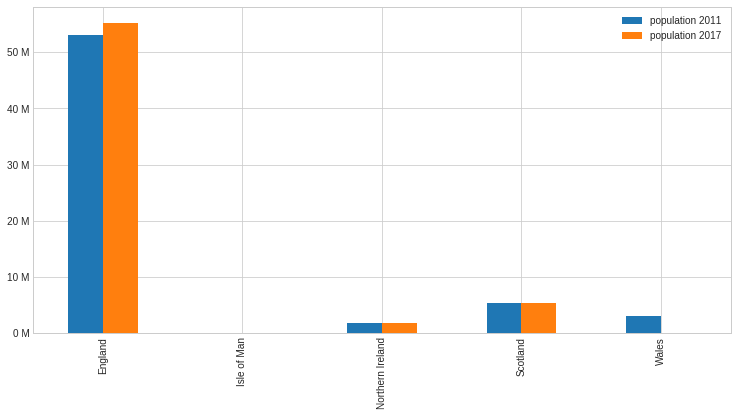

In [38]:
plot = data[['population 2011', 'population 2017']].plot(kind='bar')
ticks = ['%.0f M' % (x[1] / 1e6) for x in plot.yaxis.iter_ticks()]
plot.yaxis.set_ticklabels(ticks);  # just a hack to get nice ticks

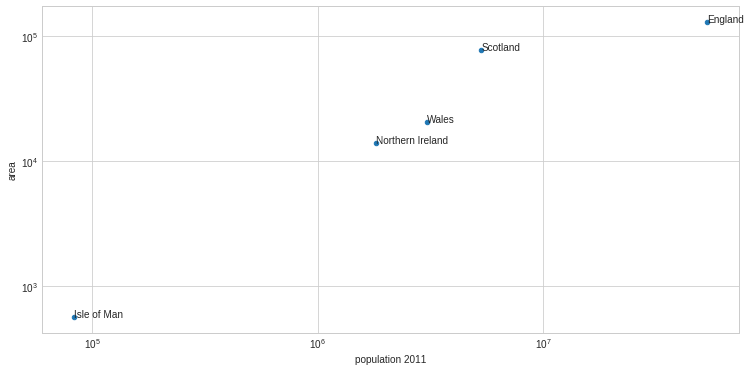

In [39]:
plot = data.plot(kind='scatter', x='population 2011', y='area', loglog=True)
for k, v in data[['population 2011', 'area']].iterrows():
    plot.axes.annotate(k, v)

### String methods

Another extra feature that does not exist in `NumPy` arrays are methods that work
on string content, just like Python string methods.  The `str` object os a `Series`
(of a column of a data frame) is used to call string methods and produce a boolean
`Series` that can then be used to retrieve rows from the data frame.

Several regular expression methods are supported as well.

In [40]:
data['capital'].str.startswith('Be')

England             False
Isle of Man         False
Northern Ireland     True
Scotland            False
Wales               False
Name: capital, dtype: bool

In [41]:
data[data.capital.str.contains('[oa]')]  # regex

,area,capital,population 2011,population 2017
England,130279,London,53012456,55268100.0
Isle of Man,572,Douglas,83314,NaN
Northern Ireland,14130,Belfast,1810863,1876695.0
Wales,20779,Cardiff,3063456,NaN


In [42]:
data[data.index.str.startswith('Eng')]

,area,capital,population 2011,population 2017
England,130279,London,53012456,55268100.0


### Missing data

More often than not real world data is incomplete in some way.
In `NumPy`, and therefore in `pandas`, missing data is represented using NaNs (not a number).
NaNs are actuall IEEE 754 float NaNs, therefore the data type of a `Series` (or `NumPy` array)
must be either a float or Python object.  `pandas` data frames have the `dropna` an `fillna`
methods that (unsurprisingly) drop or fill in values for NaNs.

Dropping can be done by row or column.  Filling can be performed in three different ways:
we can provide a value into `fillna` to substitute the NaNs for (e.g. `.fillna(0)`); or we can use
the `method=` argument to use a predefined way of filling the NaNs from the data itself.  The `method=`
can be either `pad`/`ffill` which will fill each NaN with a previous (non-NaN) value seen; or it can be
`backfill`/`bfill` which will fill a NaN from the next value.
Filling can be performed column or row wise.

In [43]:
data.dropna()  # We lost Wales and the Isle of Man!

,area,capital,population 2011,population 2017
England,130279,London,53012456,55268100.0
Northern Ireland,14130,Belfast,1810863,1876695.0
Scotland,77933,Edinburgh,5313600,5404700.0


In [44]:
data.dropna(axis='columns')  # that's better

,area,capital,population 2011
England,130279,London,53012456
Isle of Man,572,Douglas,83314
Northern Ireland,14130,Belfast,1810863
Scotland,77933,Edinburgh,5313600
Wales,20779,Cardiff,3063456


In [45]:
data_full = data.fillna(method='ffill', axis='columns')
data_full

,area,capital,population 2011,population 2017
England,130279,London,53012456,5.52681e+07
Isle of Man,572,Douglas,83314,83314
Northern Ireland,14130,Belfast,1810863,1.8767e+06
Scotland,77933,Edinburgh,5313600,5.4047e+06
Wales,20779,Cardiff,3063456,3063456


In [46]:
data_full.dtypes

area               object
capital            object
population 2011    object
population 2017    object
dtype: object

In [47]:
data_full = data_full.apply(pd.to_numeric, errors='ignore')
data_full = data_full.astype(np.integer, errors='ignore')
data_full.dtypes

area                int64
capital            object
population 2011     int64
population 2017     int64
dtype: object

In [48]:
data_full

,area,capital,population 2011,population 2017
England,130279,London,53012456,55268100
Isle of Man,572,Douglas,83314,83314
Northern Ireland,14130,Belfast,1810863,1876695
Scotland,77933,Edinburgh,5313600,5404700
Wales,20779,Cardiff,3063456,3063456
